## Initial notebook

In [128]:
# Setup
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

In [129]:
# Setup
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import SparseConvNet as sparse

In [130]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [131]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Get data from torchvision.datasets
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

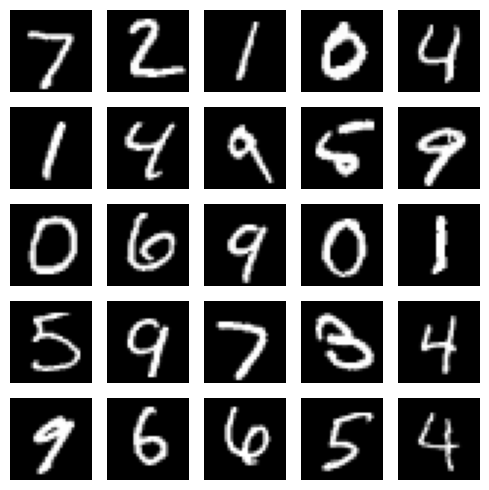

In [132]:
# Show some example images
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = test_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [133]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [260]:
class SparseConvNet(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        Initialize the layer with given params

        Args:
            in_channels: # channels that the input has.
            out_channels: # channels that the output will have.
            kernel_size: height and width of the kernel in pixels.
            stride: # pixels between adjacent receptive fields in both
                horizontal and vertical.
            padding: # pixels that is used to zero-pad the input.
        """
        super(SparseConvNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = torch.Tensor(out_channels,
                                   in_channels,
                                   kernel_size,
                                   kernel_size)
        self.bias = torch.Tensor(out_channels)
        
        # Initialize parameters
        self.init_params()
        
    
    def init_params(self,std=0.7071):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias will be zeros.
        
        Args:
            std: Standard deviation of Gaussian distribution (default: 0.7071)
        """

        self.weight = std * torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x, mask):
        """
        Forward pass of convolutional layer
        
        Args:
            x: input tensor which has a shape of (N, C, H, W)
            mask: Indicates which pixels in the input are invalid or not has a shape of (N, C, H, W) 

        Returns:
            given these definitions:
            H' = 1 + (H + 2 * padding - kernel_size) / stride
            W' = 1 + (W + 2 * padding - kernel_size) / stride
            
            output:
            y: output tensor which has a shape of (N, F, H', W')  
            pooledMask: updated mask of size (N, H', W')
        """
        

        # Pad the input
        x_padded = torch.nn.functional.pad(x, [self.padding] * 4)
        mask_padded = torch.nn.functional.pad(mask, [self.padding] * 4)
    

        # Unpack the needed dimensions
        N, C, H, W = x.shape

        # Calculate output height and width
        Hp = 1 + (H + 2 * self.padding - self.kernel_size) // self.stride
        Wp = 1 + (W + 2 * self.padding - self.kernel_size) // self.stride

        # Create an empty output to fill in
        y = torch.empty((N, self.out_channels, Hp, Wp), dtype=x.dtype, device=x.device)
        pooledMask = torch.empty((N, Hp, Wp), dtype=x.dtype, device=x.device)

        # Loop through each of the output value
        # One can find looping on input more easy but I find it more convenient
        # to loop over the output and find the corresponding input patch.
        for i in range(Hp):
            for j in range(Wp):
                # Calculate offsets on the input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get the corresponding window of the input
                convWindow = x_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size] 
                
                # mask pooling 
                poolingWindow = mask_padded[:, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                pooledMask[:, i, j], _ = poolingWindow.reshape(N, -1).max(dim=1)
                
                
                # Loop through each input sample to calculate convolution of
                # each filter and and current window of the input normalize this using the mask
                valid_pixels_amount = poolingWindow.sum()
                if valid_pixels_amount > 0:
                    for k in range(N):
                        y[k, :, i, j] =((poolingWindow[k] * convWindow[k] * self.weight).sum(dim=(1, 2, 3)) / valid_pixels_amount) + self.bias

        pooledMask = pooledMask.reshape(N, Hp, Wp)
        
        # Cache input to use in backward pass
        self.cache_mask = mask_padded
        self.cache_input = x_padded
        
        return y, pooledMask
    
    def backward(self, dupstream):
        """
        Backward pass of convolutional layer: calculate gradients of loss with
        respect to weight and bias and return downstream gradient dx.
        
        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # You don't need to implement the backward pass. Instead we give it to
        # you the solution.

        # Unpack cache
        mask_padded = self.cache_mask # This is for the mask
        x_padded = self.cache_input #This is for the convLayer

        # Create an empty dx tensor to accumulate the gradients on. Keep in mind
        # that it has a size according to padded input
        dx_padded = torch.zeros_like(x_padded)

        # Also initialize the weight gradients as zeros
        self.weight_grad = torch.zeros_like(self.weight)

        # Unpack needed dimensions
        N, _, Hp, Wp = dupstream.shape

        # Loop through dupstream
        for i in range(Hp):
            for j in range(Wp):

                # Calculate offset for current window on input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get current window of input and gradient of the input
                window = x_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                dwindow = dx_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]

                # mask_window = mask_padded[:, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                # # Walk through each sample of the input and accumulate gradients
                # # of both input and weight
                # valid_pixels_amount = mask_window.sum()
                # if valid_pixels_amount > 0:
                for k in range(N):
                    dwindow[k] += (self.weight * dupstream[k, :, i, j].view(-1, 1, 1, 1)).sum(dim=0)
                    self.weight_grad += window[k].view(1, self.in_channels, self.kernel_size, self.kernel_size) * dupstream[k, :, i, j].view(-1, 1, 1, 1)
        # Calculate actual size of input height and width
        H = x_padded.shape[2] - 2 * self.padding
        W = x_padded.shape[3] - 2 * self.padding

        # Unpad dx
        dx = dx_padded[:, :, self.padding:self.padding+H, self.padding:self.padding+W]

        # Calculate bias gradients
        self.bias_grad = dupstream.sum(dim=(0, 2, 3))

        return dx

In [261]:
class Net(nn.Module):
    """
    3-layer CNN network with max pooling
    
    Args:
        in_channels: number of features of the input image ("depth of image")
        hidden_channels: number of hidden features ("depth of convolved images")
        out_features: number of features in output layer
    """
    
    def __init__(self, in_channels, hidden_channels, out_features):
        super(Net, self).__init__()

        self.conv1 = SparseConvNet(in_channels, hidden_channels[0],
                               kernel_size=3,
                               padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = SparseConvNet(hidden_channels[0], hidden_channels[1],
                               kernel_size=5,
                               padding=2)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(7*7*hidden_channels[1], out_features)

    def forward(self, x, mask):
        # First convolutional layer
        x, mask = self.conv1(x, mask)
        # Activation function
        x = self.relu1(x)
        # Max pool
        x = self.max_pool1(x)
        # Second convolutional layer
        x, mask = self.conv2(x, mask)
        # Activation function
        x = self.relu2(x)
        # Max pool
        x = self.max_pool2(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc(x)
        return x

In [262]:
# Define the channel sizes and output dim
in_channels = 3
hidden_channels = [5, 6]
out_features = 2

net = Net(in_channels, hidden_channels, out_features)
#summary(net, (3, 28, 28), device='cpu') # (in_channels, height, width)

In [263]:
in_channels = 1 # Black-white images in MNIST digits
hidden_channels = [5, 6]
out_features = 10 

# Training parameters
learning_rate = 0.001
epochs = 3 

# Initialize network
net = Net(in_channels, hidden_channels, out_features)
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

# Try using gpu instead of cpu
device = try_gpu()

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss.detach())
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

KeyboardInterrupt: 

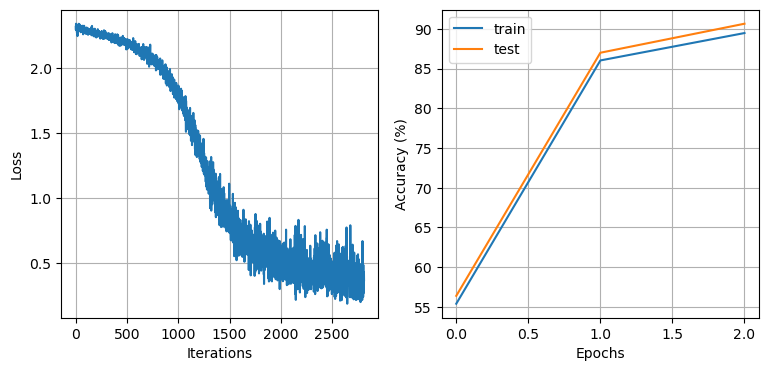

In [94]:
# Plot training curves
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()